# Predict Bike Sharing Demand with AutoGluon

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for setuptools from https://files.pythonhosted.org/packages/bb/26/7945080113158354380a12ce26873dd6c1ebd88d47f5bc24e2c5bb38c16a/setuptools-68.2.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080016 sha256=4f2acb95481ab308a4340c6b4b16d8324308e6c5e6d82b7fcad40e4ee3442ae7
  Stored in directory: /root/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.2.2
    Uninstalling bokeh-3.2.2:
      Successfully uninstalled bokeh-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.2.2 requires bokeh<3.3.

### Setup Kaggle API Key

In [1]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "zenretbakle"
kaggle_key = "4b106c2a5ab760340c4a1ca3bba5b01b"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms

In [3]:
! pip install kaggle

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

100% 189k/189k [00:00<00:00, 555kB/s]
100% 189k/189k [00:00<00:00, 554kB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
!ls

bike-sharing-demand.zip  sample_data  sampleSubmission.csv  test.csv  train.csv


In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [2]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<ipython-input-3-a917dec577f8>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


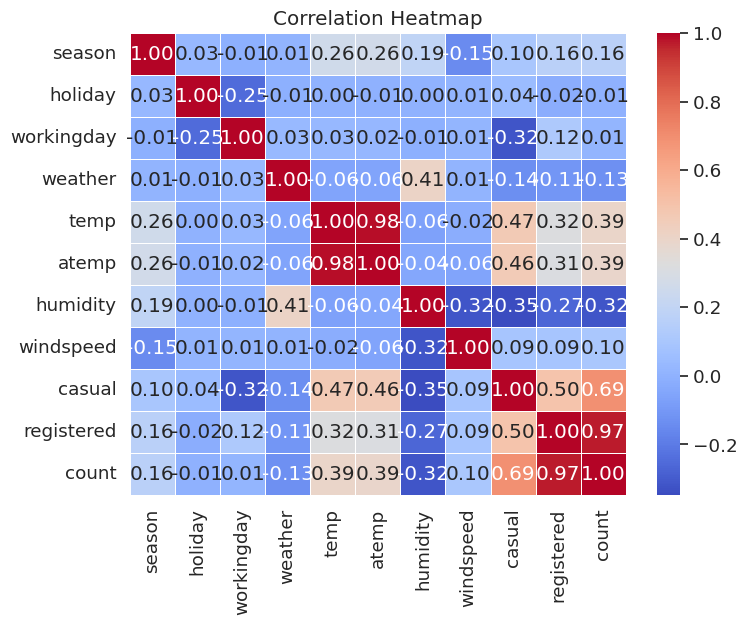

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a heatmap of correlation values
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
train["season"].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

In [ ]:
train["weather"].value_counts()
#further more

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [10]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [5]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=['datetime'])
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [12]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [13]:
train_only = train.drop(["registered", "casual"], axis=1)

In [14]:
train_only.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [15]:
predictor = TabularPredictor("count", eval_metric="root_mean_squared_error").fit(
    train_data=train_only,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230921_153821/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230921_153821/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   82.88 GB / 115.66 GB (71.7%)
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of:

In [41]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  regression
AutoGluon identified the following types of features:
('float', [])                : 3 | ['temp', 'atemp', 'windspeed']
('int', [])                  : 3 | ['season', 'weather', 'humidity']
('int', ['bool'])            : 2 | ['holiday', 'workingday']
('int', ['datetime_as_int']) : 5 | ['datetime', 'datetime.year', 'datetime.month', 'datetime.day', 'datetime.dayofweek']


### Review AutoGluon's training run with ranking of models that did the best.

In [17]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.018449      34.340436  573.730538                0.000788           0.268685            3       True         13
1   RandomForestMSE_BAG_L2  -53.323242      27.873003  452.103441                0.736575          47.670753            2       True         12
2          LightGBM_BAG_L2  -54.983907      27.512271  440.983701                0.375843          36.551012            2       True         11
3        LightGBMXT_BAG_L2  -60.514077      33.227231  489.240087                6.090802          84.807399            2       True         10
4    KNeighborsDist_BAG_L1  -84.125061       0.086653    0.050640                0.086653           0.050640            1       True          2
5      WeightedEnsemble_L2  -84.125061       0.087841    0.873779         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.81911375834474

### Create predictions from test dataset

In [18]:
predictions = predictor.predict(test)
predictions.head()

0    22.856861
1    44.155987
2    47.590034
3    49.440334
4    52.112976
Name: count, dtype: float32

In [19]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.537781
std        89.879372
min         3.408976
25%        19.813885
50%        63.317276
75%       166.350159
max       366.604523
Name: count, dtype: float64

In [ ]:
# How many negative values do we have?
negatives = 0

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions
submission.head()
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:02<00:00, 66.2kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-05-29 20:16:52  features with hyperparameters      complete  0.50354      0.50354       
submission_new_features.csv  2023-05-29 13:36:35  new features2                      complete  0.54343      0.54343       
submission_new_hpo.csv       2023-05-24 22:07:59  new features with hyperparameters  complete  0.68666      0.68666       
submission_new_hpo.csv       2023-05-24 21:12:40  new features with hyperparameters  complete  0.58564      0.58564       


#### Initial score of `1.80755`

## Step 4: Exploratory Data Analysis and Creating an additional feature

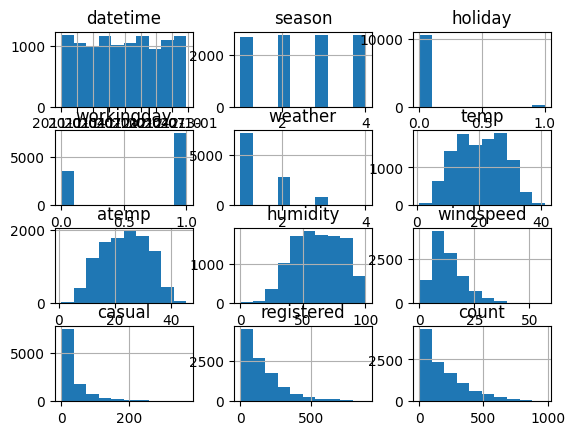

In [21]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist();

In [22]:
# create a new feature
train[['hour', 'day', 'month']] = train['datetime'].apply(lambda x: pd.Series([x.hour, x.day, x.month]))
test[['hour', 'day', 'month']] = test['datetime'].apply(lambda x: pd.Series([x.hour, x.day, x.month]))

In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1


In [ ]:
# train = train.drop("atemp", axis=1)
# test = test.drop("atemp", axis=1)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [6]:
# convert to from numerical to categorical values
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
train["holiday"] = train["holiday"].astype("category")
train["workingday"] = train["workingday"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")
test["holiday"] = test["holiday"].astype("category")
test["workingday"] = test["workingday"].astype("category")

In [9]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_diff,wind_humid_interaction
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,4.555,0.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,4.615,0.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,4.615,0.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,4.555,0.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4.555,0.0


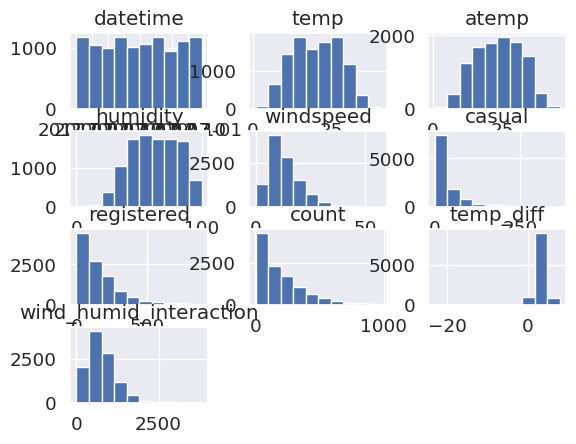

In [11]:
# View histogram of all features again now with the hour feature
train.hist();

## Step 5: Rerun the model with the same settings as before, just with more features

<ipython-input-13-6919b5f70d87>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


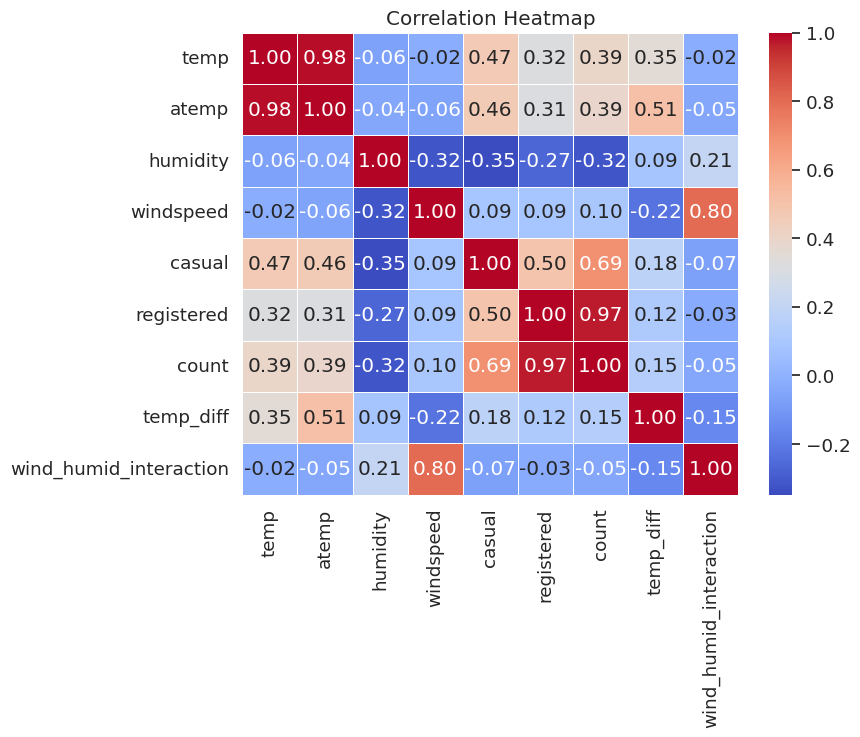

In [13]:
# Create a heatmap of correlation values
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
train_only2.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'temp_diff',
       'wind_humid_interaction'],
      dtype='object')

In [16]:
train_only2 = train.drop(["datetime","casual","registered", "atemp", 'temp_diff', 'wind_humid_interaction'], axis=1)

In [17]:
train_only2.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'windspeed', 'count'],
      dtype='object')

In [18]:
predictor_new_features = TabularPredictor("count", eval_metric="root_mean_squared_error").fit(
    train_data=train_only2,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230921_164820/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230921_164820/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   80.25 GB / 115.66 GB (69.4%)
Train Data Rows:    10886
Train Data Columns: 7
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of:

In [19]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -140.251098      10.006675  559.664902                0.001249           0.335355            3       True         14
1        LightGBMXT_BAG_L2 -141.002449       8.431281  424.924170                1.164816          44.208580            2       True         10
2          LightGBM_BAG_L2 -141.137618       7.482211  418.522447                0.215746          37.806857            2       True         11
3          CatBoost_BAG_L2 -141.145322       7.468734  434.456934                0.202268          53.741344            2       True         13
4      WeightedEnsemble_L2 -141.483611       6.262982  191.017633                0.001397           0.674969            2       True          9
5   RandomForestMSE_BAG_L2 -142.030044       8.422596  423.572767         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -165.14207054922935,
  'KNeighborsDist_BAG_L1': -179.4216148241622,
  'LightGBMXT_BAG_L1': -143.42886109259382,
  'LightGBM_BAG_L1': -144.26047240966562,
  'RandomForestMSE_BAG_L1': -151.

In [20]:
predictor_new_features.leaderboard()

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -140.251098      10.006675  559.664902                0.001249           0.335355            3       True         14
1        LightGBMXT_BAG_L2 -141.002449       8.431281  424.924170                1.164816          44.208580            2       True         10
2          LightGBM_BAG_L2 -141.137618       7.482211  418.522447                0.215746          37.806857            2       True         11
3          CatBoost_BAG_L2 -141.145322       7.468734  434.456934                0.202268          53.741344            2       True         13
4      WeightedEnsemble_L2 -141.483611       6.262982  191.017633                0.001397           0.674969            2       True          9
5   RandomForestMSE_BAG_L2 -142.030044       8.422596  423.572767                1.156131          42.857177            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-140.251098,10.006675,559.664902,0.001249,0.335355,3,True,14
1,LightGBMXT_BAG_L2,-141.002449,8.431281,424.924170,1.164816,44.208580,2,True,10
2,LightGBM_BAG_L2,-141.137618,7.482211,418.522447,0.215746,37.806857,2,True,11
3,CatBoost_BAG_L2,-141.145322,7.468734,434.456934,0.202268,53.741344,2,True,13
4,WeightedEnsemble_L2,-141.483611,6.262982,191.017633,0.001397,0.674969,2,True,9
5,RandomForestMSE_BAG_L2,-142.030044,8.422596,423.572767,1.156131,42.857177,2,True,12
6,LightGBMXT_BAG_L1,-143.428861,3.709088,49.082088,3.709088,49.082088,1,True,3
7,LightGBM_BAG_L1,-144.260472,0.606938,33.420238,0.606938,33.420238,1,True,4
8,CatBoost_BAG_L1,-145.135578,0.183466,183.104384,0.183466,183.104384,1,True,6
9,NeuralNetFastAI_BAG_L1,-147.021964,1.036196,100.629514,1.036196,100.629514,1,True,8


In [ ]:
model_names = predictor_new_features.get_model_names()
print(model_names)

['KNeighborsUnif_BAG_L1', 'KNeighborsDist_BAG_L1', 'LightGBMXT_BAG_L1', 'LightGBM_BAG_L1', 'RandomForestMSE_BAG_L1', 'CatBoost_BAG_L1', 'WeightedEnsemble_L2', 'LightGBMXT_BAG_L2', 'LightGBM_BAG_L2', 'RandomForestMSE_BAG_L2', 'CatBoost_BAG_L2', 'WeightedEnsemble_L3']


In [21]:
# Remember to set all negative values to zero
predictions = predictor_new_features.predict(test)
predictions.head()

0    120.375717
1     62.228611
2     62.228611
3     90.767365
4     90.767365
Name: count, dtype: float32

In [31]:
predictions.describe()

count    6493.000000
mean      189.181595
std       165.277954
min         3.029382
25%        49.585457
50%       153.052963
75%       275.857056
max       819.011597
Name: count, dtype: float64

In [22]:
submission_new_features = pd.read_csv("sampleSubmission.csv")
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [23]:
# Same submitting predictions
submission_new_features["count"] = predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [24]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features3"

100% 188k/188k [00:02<00:00, 67.2kB/s] 
Successfully submitted to Bike Sharing Demand

In [25]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-09-21 17:01:47  new features3                      complete  1.32428      1.32428       
submission_new_features.csv  2023-09-21 16:11:06  new features2                      complete  0.54339      0.54339       
submission_new_hpo.csv       2023-05-29 20:16:52  features with hyperparameters      complete  0.50354      0.50354       
submission_new_features.csv  2023-05-29 13:36:35  new features2                      complete  0.54343      0.54343       


#### New Score of `0.54343`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
import autogluon.core as ag


search_space_lightgbm = {
    'num_leaves': ag.space.Int(10, 100),
    'learning_rate': ag.space.Real(0.01, 0.1),
    'min_data_in_leaf': ag.space.Int(1, 30),
    'feature_fraction': ag.space.Real(0.5, 1.0),
    'bagging_fraction': ag.space.Real(0.5, 1.0),
    'bagging_freq': ag.space.Int(0, 5)
}

search_space_randomforest = {
    'n_estimators': ag.space.Int(50, 100),
    'max_depth': ag.space.Int(5, 20),
    'min_samples_split': ag.space.Int(2, 10),
    'min_samples_leaf': ag.space.Int(1, 10)
}

search_space_xgboost = {'objective':'reg:gamma',
                        'booster':'gbtree',
                        'base_score':3,
                        "eval_metric": "rmse"}


hyperparameters = {
                   'GBM': search_space_lightgbm,
                   'RF': search_space_randomforest,
                   "XGB":search_space_xgboost
                  }

time_limit = 1.5*60
num_trials = 3
search_strategy = 'auto'
hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [ ]:
predictor_new_hpo = TabularPredictor("count", eval_metric="root_mean_squared_error").fit(
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    train_data=train_only2,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230529_200519/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230529_200519/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 10
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-61.33	 = Validation score   (-root_mean_squared_error)
	113.43s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: RandomForest_BAG_L1 ... Tuning model for up to 119.94s of the 480.16s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

Fitted model: RandomForest_BAG_L1/T1 ...
	-111.4975	 = Validation score   (-root_mean_squared_error)
	1.19s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: RandomForest_BAG_L1/T2 ...
	-69.4998	 = Validation score   (-root_mean_squared_error)
	2.24s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: RandomForest_BAG_L1/T3 ...
	-68.4806	 = Validation score   (-root_mean_squared_error)
	2.47s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L1 ... Tuning model for up to 119.94s of the 474.11s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	-52.7519	 = Validation score   (-root_mean_squared_error)
	105.97s	 = Training   runtime
	0.0s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 368.03s of remaining time.
	-52.3464	 = Validation score   (-root_mean_squared_error)
	0.33s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 3 L2 models ...
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 110.3s of the 367.67s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L2/T1 ...
	-52.8299	 = Validation score   (-root_mean_squared_error)
	44.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-52.7887	 = Validation score   (-root_mean_squared_error)
	32.94s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: RandomForest_BAG_L2 ... Tuning model for up to 110.3s of the 290.01s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

Fitted model: RandomForest_BAG_L2/T1 ...
	-52.7987	 = Validation score   (-root_mean_squared_error)
	1.43s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: RandomForest_BAG_L2/T2 ...
	-53.9114	 = Validation score   (-root_mean_squared_error)
	4.82s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: RandomForest_BAG_L2/T3 ...
	-53.8111	 = Validation score   (-root_mean_squared_error)
	6.34s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L2 ... Tuning model for up to 110.3s of the 277.26s of remaining time.


  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L2/T1 ...
	-52.7959	 = Validation score   (-root_mean_squared_error)
	39.23s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T2 ...
	-52.6653	 = Validation score   (-root_mean_squared_error)
	43.52s	 = Training   runtime
	0.0s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 194.34s of remaining time.
	-52.2582	 = Validation score   (-root_mean_squared_error)
	0.47s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 406.18s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230529_200519/")


In [ ]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.258207       0.003343  393.848150                0.001228           0.474064            3       True         14
1      WeightedEnsemble_L2  -52.346363       0.001626  219.731378                0.001090           0.330098            2       True          6
2        XGBoost_BAG_L2/T2  -52.665335       0.001281  268.818559                0.000172          43.517102            2       True         13
3        XGBoost_BAG_L1/T1  -52.751854       0.000169  105.969271                0.000169         105.969271            1       True          5
4       LightGBM_BAG_L2/T2  -52.788711       0.001263  258.245656                0.000154          32.944199            2       True          8
5        XGBoost_BAG_L2/T1  -52.795912       0.001274  264.534735         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1/T1': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T2': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L1/T3': 'StackerEnsembleModel_RF',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2/T1': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L2/T2': 'StackerEnsembleModel_RF',
  'RandomForest_BAG_L2/T3': 'StackerEnsembleModel_RF',
  'XGBoost_BAG_L2/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L2/T2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -61.329960069638595,
  'RandomForest_BAG_L1/T1': -111.49745905077886,
  'RandomForest_BAG_L1/T2': -69.49979659012338,
  'RandomForest_BAG_L1/T3': -68.4805875626221,
  'XGBoost_BAG_L1/T1': 

In [ ]:
predictor_new_hpo.leaderboard()


                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.258207       0.003343  393.848150                0.001228           0.474064            3       True         14
1      WeightedEnsemble_L2  -52.346363       0.001626  219.731378                0.001090           0.330098            2       True          6
2        XGBoost_BAG_L2/T2  -52.665335       0.001281  268.818559                0.000172          43.517102            2       True         13
3        XGBoost_BAG_L1/T1  -52.751854       0.000169  105.969271                0.000169         105.969271            1       True          5
4       LightGBM_BAG_L2/T2  -52.788711       0.001263  258.245656                0.000154          32.944199            2       True          8
5        XGBoost_BAG_L2/T1  -52.795912       0.001274  264.534735                0.000165          39.233278            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-52.258207,0.003343,393.848150,0.001228,0.474064,3,True,14
1,WeightedEnsemble_L2,-52.346363,0.001626,219.731378,0.001090,0.330098,2,True,6
2,XGBoost_BAG_L2/T2,-52.665335,0.001281,268.818559,0.000172,43.517102,2,True,13
3,XGBoost_BAG_L1/T1,-52.751854,0.000169,105.969271,0.000169,105.969271,1,True,5
4,LightGBM_BAG_L2/T2,-52.788711,0.001263,258.245656,0.000154,32.944199,2,True,8
5,XGBoost_BAG_L2/T1,-52.795912,0.001274,264.534735,0.000165,39.233278,2,True,12
6,RandomForest_BAG_L2/T1,-52.798714,0.001254,226.734380,0.000144,1.432923,2,True,9
7,LightGBM_BAG_L2/T1,-52.829924,0.001293,269.906133,0.000184,44.604676,2,True,7
8,RandomForest_BAG_L2/T3,-53.811130,0.001295,231.641910,0.000186,6.340453,2,True,11
9,RandomForest_BAG_L2/T2,-53.911446,0.001288,230.124564,0.000179,4.823107,2,True,10


In [ ]:
model_names = predictor_new_hpo.get_model_names()

print(model_names)

['LightGBM_BAG_L1/T1', 'RandomForest_BAG_L1/T1', 'RandomForest_BAG_L1/T2', 'RandomForest_BAG_L1/T3', 'XGBoost_BAG_L1/T1', 'WeightedEnsemble_L2', 'LightGBM_BAG_L2/T1', 'LightGBM_BAG_L2/T2', 'RandomForest_BAG_L2/T1', 'RandomForest_BAG_L2/T2', 'RandomForest_BAG_L2/T3', 'XGBoost_BAG_L2/T1', 'XGBoost_BAG_L2/T2', 'WeightedEnsemble_L3']


In [ ]:
# Remember to set all negative values to zero
predictions = predictor_new_hpo.predict(test)
predictions.head()

0    16.262354
1     7.017554
2     6.753581
3     5.514184
4     5.514169
Name: count, dtype: float32

In [ ]:
submission_new_hpo = pd.read_csv("sampleSubmission.csv")
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [ ]:
# Same submitting predictions
submission_new_hpo["count"] = predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "features with hyperparameters"

100% 188k/188k [00:02<00:00, 67.7kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-05-29 20:16:52  features with hyperparameters      complete  0.50354      0.50354       
submission_new_features.csv  2023-05-29 13:36:35  new features2                      complete  0.54343      0.54343       
submission_new_hpo.csv       2023-05-24 22:07:59  new features with hyperparameters  complete  0.68666      0.68666       
submission_new_hpo.csv       2023-05-24 21:12:40  new features with hyperparameters  complete  0.58564      0.58564       


#### New Score of `0.50354`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.088, -50.025, -52.258207]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80755, 0.54343 , 0.50354]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [?, ?, ?],
    "hpo2": [?, ?, ?],
    "hpo3": [?, ?, ?],
    "score": [?, ?, ?]
})